Path to dataset files: /root/.cache/kagglehub/datasets/thedevastator/online-retail-transaction-records/versions/1

----- Logistic Regression -----
Logistic Regression Performance:
Accuracy: 0.7138239559521176
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.81      0.74     40696
           1       0.76      0.62      0.68     40670

    accuracy                           0.71     81366
   macro avg       0.72      0.71      0.71     81366
weighted avg       0.72      0.71      0.71     81366



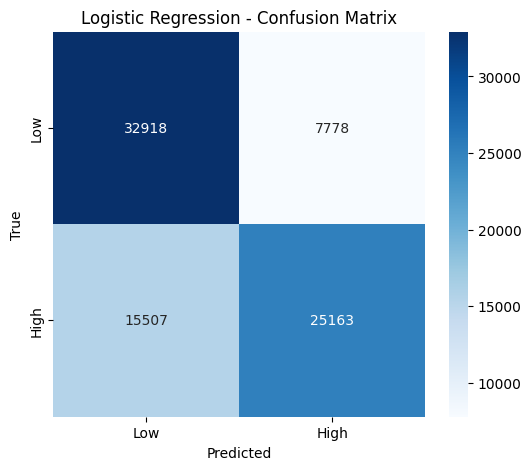


----- Random Forest -----
Random Forest Performance:
Accuracy: 0.7922350859081189
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.76      0.79     40696
           1       0.77      0.83      0.80     40670

    accuracy                           0.79     81366
   macro avg       0.79      0.79      0.79     81366
weighted avg       0.79      0.79      0.79     81366



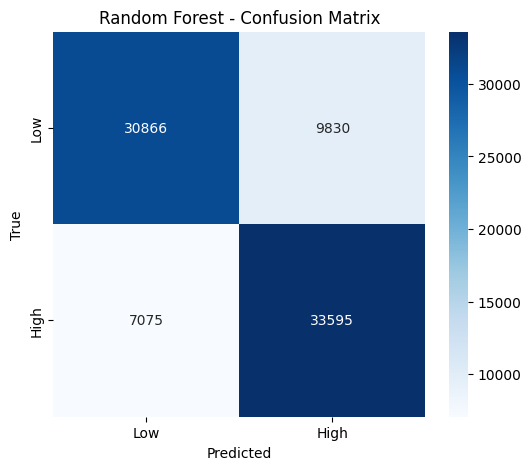

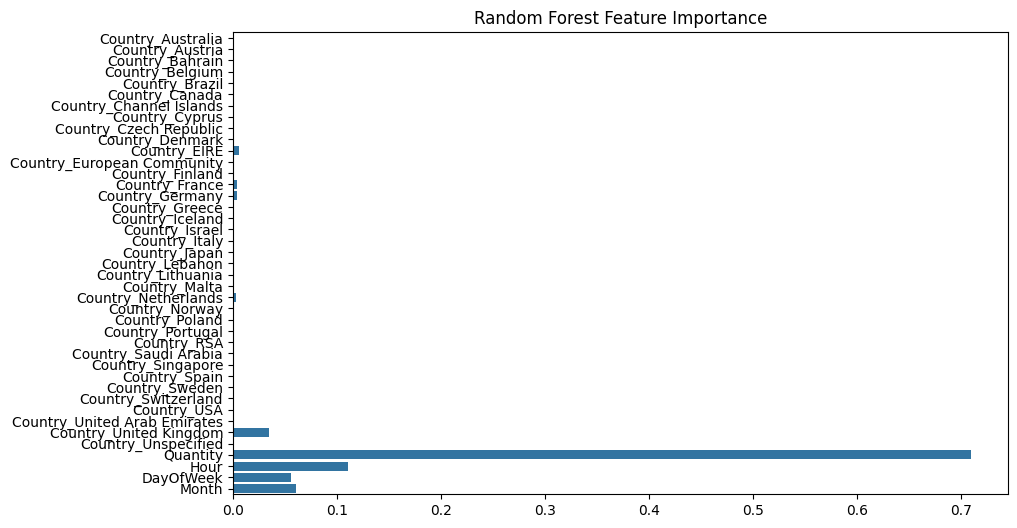


----- Ensemble Method -----
Ensemble Model Performance:
Accuracy: 0.7894820932576261
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79     40696
           1       0.78      0.80      0.79     40670

    accuracy                           0.79     81366
   macro avg       0.79      0.79      0.79     81366
weighted avg       0.79      0.79      0.79     81366



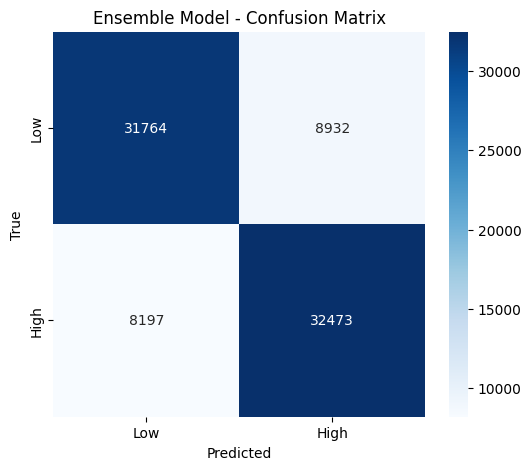

<ipython-input-52-6eea7163f82d>:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


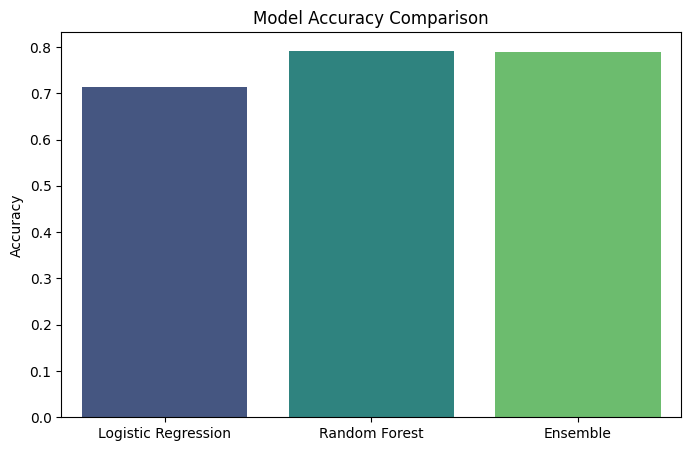

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

path = kagglehub.dataset_download("thedevastator/online-retail-transaction-records")
print("Path to dataset files:", path)

# Load and preprocess dataset
data = pd.read_csv(f"{path}/Online Retail.csv", encoding='latin1').dropna()
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Hour'] = data['InvoiceDate'].dt.hour
data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek
data['Month'] = data['InvoiceDate'].dt.month
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Define target variable ('HighValuePurchase') and features
y = (data['TotalPrice'] > data['TotalPrice'].median()).astype(int)
X = data.drop(['TotalPrice', 'InvoiceNo', 'Description', 'InvoiceDate'], axis=1)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('country', OneHotEncoder(handle_unknown='ignore'), ['Country']),
        ('num', 'passthrough', ['Quantity', 'Hour', 'DayOfWeek', 'Month'])
    ])

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Helper function for confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Logistic Regression
print("\n----- Logistic Regression -----")
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
logreg_pipeline.fit(X_train, y_train)
logreg_preds = logreg_pipeline.predict(X_test)

# Logistic Regression Evaluation
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, logreg_preds)}")
print("Classification Report:\n", classification_report(y_test, logreg_preds))
plot_confusion_matrix(y_test, logreg_preds, "Logistic Regression - Confusion Matrix")

# Random Forest
print("\n----- Random Forest -----")
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)

# Random Forest Evaluation
print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, rf_preds)}")
print("Classification Report:\n", classification_report(y_test, rf_preds))
plot_confusion_matrix(y_test, rf_preds, "Random Forest - Confusion Matrix")

# Feature importance for Random Forest
rf_feature_importance = rf_pipeline.named_steps['classifier'].feature_importances_
rf_features = list(preprocessor.transformers_[0][1].get_feature_names_out()) + ['Quantity', 'Hour', 'DayOfWeek', 'Month']
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_feature_importance, y=rf_features)
plt.title("Random Forest Feature Importance")
plt.show()

# Ensemble Method
print("\n----- Ensemble Method -----")
ensemble_model = VotingClassifier(
    estimators=[
        ('logreg', logreg_pipeline.named_steps['classifier']),
        ('rf', rf_pipeline.named_steps['classifier'])
    ],
    voting='soft'
)
ensemble_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ensemble_model)
])
ensemble_pipeline.fit(X_train, y_train)
ensemble_preds = ensemble_pipeline.predict(X_test)

# Ensemble Model Evaluation
print("Ensemble Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, ensemble_preds)}")
print("Classification Report:\n", classification_report(y_test, ensemble_preds))
plot_confusion_matrix(y_test, ensemble_preds, "Ensemble Model - Confusion Matrix")

# Compare Model Performances
models = ['Logistic Regression', 'Random Forest', 'Ensemble']
accuracies = [
    accuracy_score(y_test, logreg_preds),
    accuracy_score(y_test, rf_preds),
    accuracy_score(y_test, ensemble_preds)
]
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()
